# Problem Description
Tiny ImageNet contains 100'000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images and 50 test images.

# Metrics
For the evaluation of the model, we will use accuracy as our metric. It is straightforward and defined as follows:
$$ \text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}} $$

However, accuracy has a disadvantage for multiclass classification problems, as it does not consider class imbalances. If our model is biased towards one class, and that class has the highest occurrence, accuracy may fail to reflect this bias. In our case, since the dataset does not have class imbalances, accuracy should be sufficient for our evaluation.

To estimate the error in the chosen metric, we could also consider using an alternative metric like the F1 Score, which penalizes false predictions rather than just summarizing the correct ones.


# Base Architecture

- We stack convolutional, linear and pooling layers together for image classification problem
- Convolutional layers detect hierarchical patterns and learn local features
- Linear layers learn global patterns across features and map to the output space
- Pooling layers between convolutional and linear layers reduce dimensionality and provide translation invariance

Initial architecture:
- Conv 3x3 kernel, 3→16 channels 
- MaxPool
- Conv 3x3 kernel, 16→32 channels
- MaxPool
- Linear 500 units
- Linear 500 units

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import utils
from typing import List, Tuple, Dict


class CNN(nn.Module):
    def __init__(
        self,
        dim: int,
        num_classes: int,
        confs: List[Tuple[str, Dict]],
        in_channels: int,
        weight_init=None,
    ):
        super(CNN, self).__init__()
        self.net = nn.ModuleList()
        self.weight_init = weight_init

        linear_idxs = [idx for idx, (layer, _) in enumerate(confs) if layer == "L"]
        linear_start = linear_idxs[0]
        convolution_conf = confs[:linear_start]
        linear_conf = confs[linear_start:]

        current_channels = in_channels
        for layer, conf in convolution_conf:
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        current_channels,
                        out_channels=conf["channels"],
                        kernel_size=conf.get("kernel", 3),
                        stride=conf.get("stride", 1),
                        padding=conf.get("padding", 0),
                    )
                )
                self.net.append(nn.ReLU())
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm2d(conf["channels"]))
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
                current_channels = conf["channels"]
            elif layer == "P":
                self.net.append(nn.MaxPool2d(kernel_size=conf["kernel"]))

        self.dim = utils.get_dim_after_conv_and_pool(
            dim_init=dim, confs=convolution_conf
        )

        current_units = self.dim * self.dim * current_channels
        for idx, (layer, conf) in enumerate(linear_conf):
            if idx == 0:
                self.net.append(nn.Flatten())
                self.net.append(nn.Linear(current_units, conf["units"]))
                current_units = conf["units"]
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))
            elif idx == len(linear_conf) - 1:
                self.net.append(nn.Linear(current_units, num_classes))
            else:
                self.net.append(nn.Linear(current_units, conf["units"]))
                current_units = conf["units"]
                if conf.get("batch_norm", False):
                    self.net.append(nn.BatchNorm1d(conf["units"]))
                self.net.append(nn.ReLU())
                if conf.get("dropout", 0):
                    self.net.append(nn.Dropout(conf["dropout"]))

        if self.weight_init is not None:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.net:
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if self.weight_init == "kaiming":
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                elif self.weight_init == "random":
                    nn.init.uniform_(m.weight, -0.1, 0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.shape[1] != 3:
            x = x.permute(0, 3, 1, 2)
        assert (
            x.shape[1] == 3
        ), f"Expected 3 channels in dimension 1, got shape {x.shape}"

        for layer in self.net:
            x = layer(x)

        return x


In [2]:
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]

In [3]:
x = torch.rand(10, 64, 64, 3)
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
model(x)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 32, 29, 29]           4,640
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
              ReLU-9                  [-1, 500]               0
           Linear-10                  [-1, 200]         100,200
Total params: 3,241,788
Trainable params: 3,241,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.57
Params size (MB): 12.37
Estima

# SGD, Tuning of Learning Rate and Batch Size
- Stochastic Gradient Descent (SGD) is an optimization method. Unlike traditional gradient descent, where we train on the entire dataset, SGD updates model parameters using a small batch of the data. This enables faster learning, say faster convergence to local (global) minima, and is therefore more efficient.
- The learning rate controls how much the model's weights are adjusted in response to the error at each step of training. A small learning rate increases the training time, while a large learning rate speeds up training but can cause the model to overshoot and fail to converge.
- The batch size refers to the number of training examples used for updating the model's weights. The key idea is that using smaller groups to update the weights will also allow the model to generalize well, as the batch acts as a proxy for the whole dataset.

First, we'll conduct an overfitting test by training on a small dataset of 100 samples, expecting the loss to decrease and accuracy to increase. Then, we'll search for the highest learning rate that still allows convergence. Finally, we'll determine a batch size that is memory efficient and balances representation of the data statistics with minimizing noise.

In [ ]:
# Check if learning algorithm works

import torch.optim as optim
import importlib
import train_eval
importlib.reload(train_eval)
from train_eval import train
from utils import get_data
import matplotlib.pyplot as plt

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
train_loader, valid_loader = get_data(batch_size=100, subset_size=100, seed=42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
history = train(
    model,
    epochs=200,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=None,
    train_only=True,
)


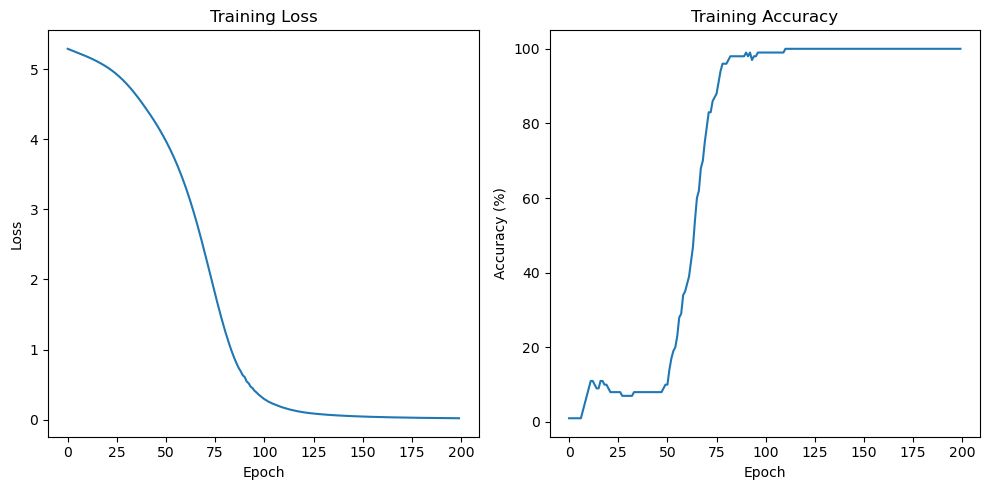

In [11]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_accuracy"])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [ ]:
# Tuning of Learning Rate and Batch Size

import json

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
device = torch.device("mps" if torch.backends.mps.is_available() else None)
criterion = nn.CrossEntropyLoss()
learning_rates = [ 0.001, 0.01, 0.05]
batch_sizes = [32, 64, 128]
lr_bs_results = {}
epochs = 15
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    for bs in batch_sizes:
        print(f"Batch size: {bs}")
        train_loader, valid_loader = get_data(batch_size=bs, seed=42)
        model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
        if device is not None:
            model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        history = train(
            model,
            epochs=epochs,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        name = f"lr={lr}, bs={bs}"
        lr_bs_results[name] = history

with open("results/lr_bs_results.json", "w") as f:
    json.dump(lr_bs_results, f)


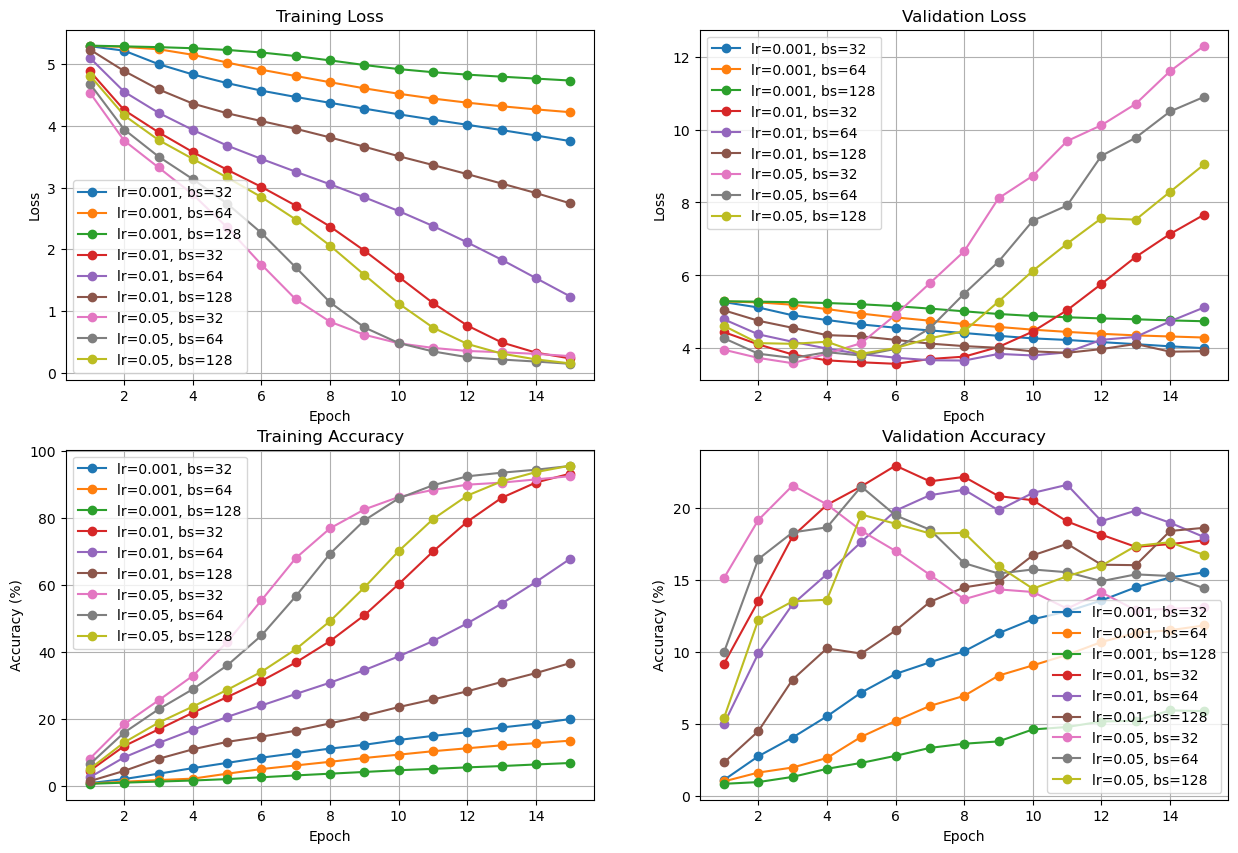

In [60]:
import importlib
import plot_lr_bs
importlib.reload(plot_lr_bs)
from plot_lr_bs import plot_lr_bs_results
with open("results/lr_bs_results.json", "r") as f:
    lr_bs_results = json.load(f)
plot_lr_bs_results(lr_bs_results)

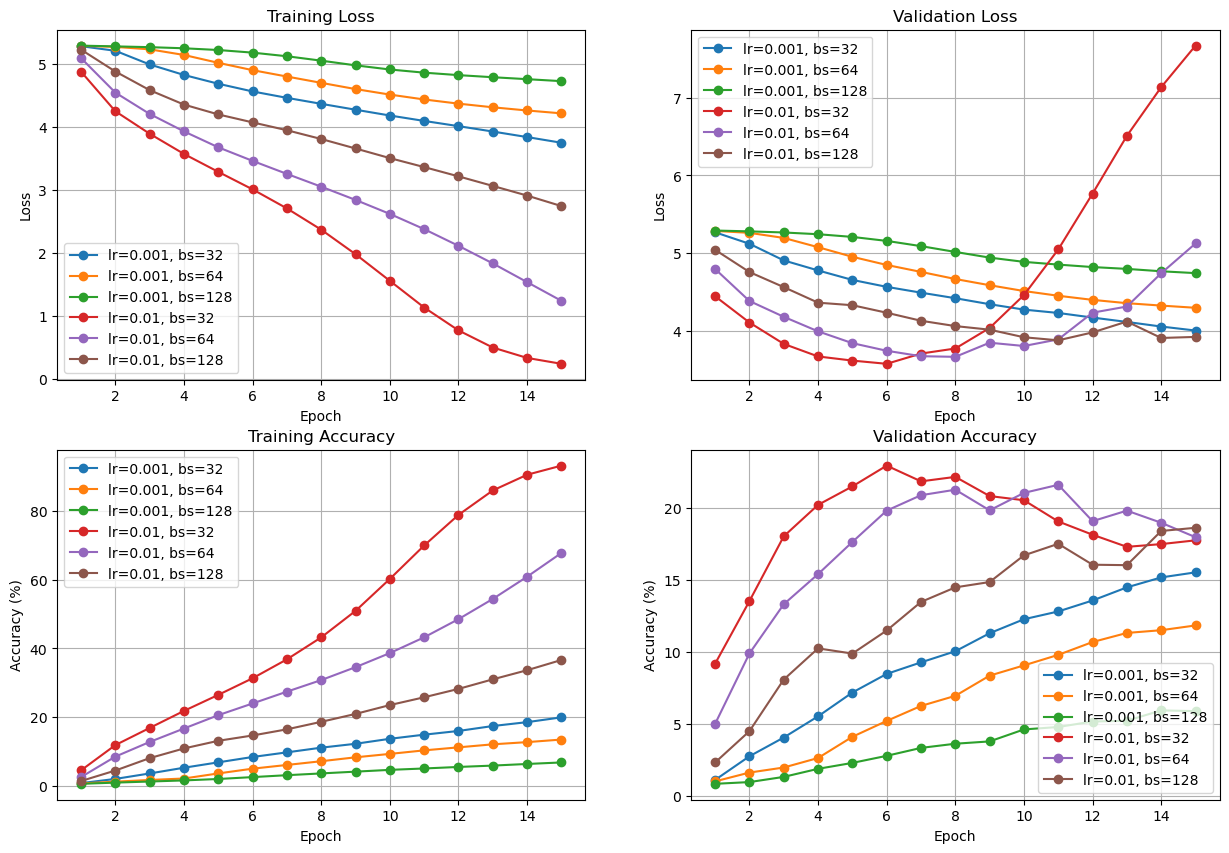

In [63]:
with open("results/lr_bs_results.json", "r") as f:
    lr_bs_results = json.load(f)
remove = ["lr=0.05, bs=128", "lr=0.05, bs=64", "lr=0.05, bs=32"]
for key in remove:
    lr_bs_results.pop(key)
plot_lr_bs_results(lr_bs_results)

## Discussion
Our overfitting test with SGD and 100 samples (full batch) shows that the algorithm works. It converges as expected, and the accuracy increases up to 100% and clearly shows overfitting.

For the right learning rate and batch size, we can observe:
- **lr=0.05, any batch size**
  - Overfits too early and therefore shows bad performance in generalizing
- **lr=0.001, any batch size**
  - Too slow in convergence, therefore needs too many compute resources
- **lr=0.01, bs=32**
  - Skyrocketing validation loss after 6 epochs, therefore prone to perform badly on unseen data
- **lr=0.01, bs=64 and bs=128**
  - Good trade-off between convergence and overfitting
  - bs=64 converges faster than bs=128 and needs less memory for training

**Conclusion**
We will go with lr=0.01 and batch size=64, because:
- Best trade-off between convergence and overfitting
- Computationally more efficient

# SGD, Weight Initialization, Model Complexity, Convolution Settings

For this section will do the following things:
1) Examine the effect of different weight initializations
2) Test various model complexities, say different number-, units- and filters per layer
3) Figure out which convolutional settings for kernel, padding and stride gives the best performance

## Weight Initialization

1. **kaiming_normal**: Initializes weights from a normal distribution scaled by √(2/n_in), optimized for ReLU activations.

2. **kaiming_uniform**: Similar to kaiming_normal but uses a uniform distribution within bounds of ±√(6/n_in).

3. **normal**: Samples weights from a standard normal distribution without any scaling.

4. **uniform**: Draws weights from a uniform distribution between -0.1 and 0.1.

5. **ones**: Sets all weights to 1

In [ ]:
# Run Different Weight Initialization

import json
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
import cnn

importlib.reload(cnn)
from cnn import CNN
from utils import get_data
from train_eval import train

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]

device = torch.device("mps" if torch.backends.mps.is_available() else None)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
epochs = 10
weight_init_results = {}

for init_type in [
    "kaiming_normal",
    "kaiming_uniform",
    "normal",
    "uniform",
    "ones",
]:
    model = CNN(
        dim=64, num_classes=200, confs=confs, in_channels=3, weight_init=init_type
    )
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    history = train(
        model,
        epochs=epochs,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )

    weight_init_results[init_type] = history

with open("results/weight_init_results.json", "w") as f:
    json.dump(weight_init_results, f)

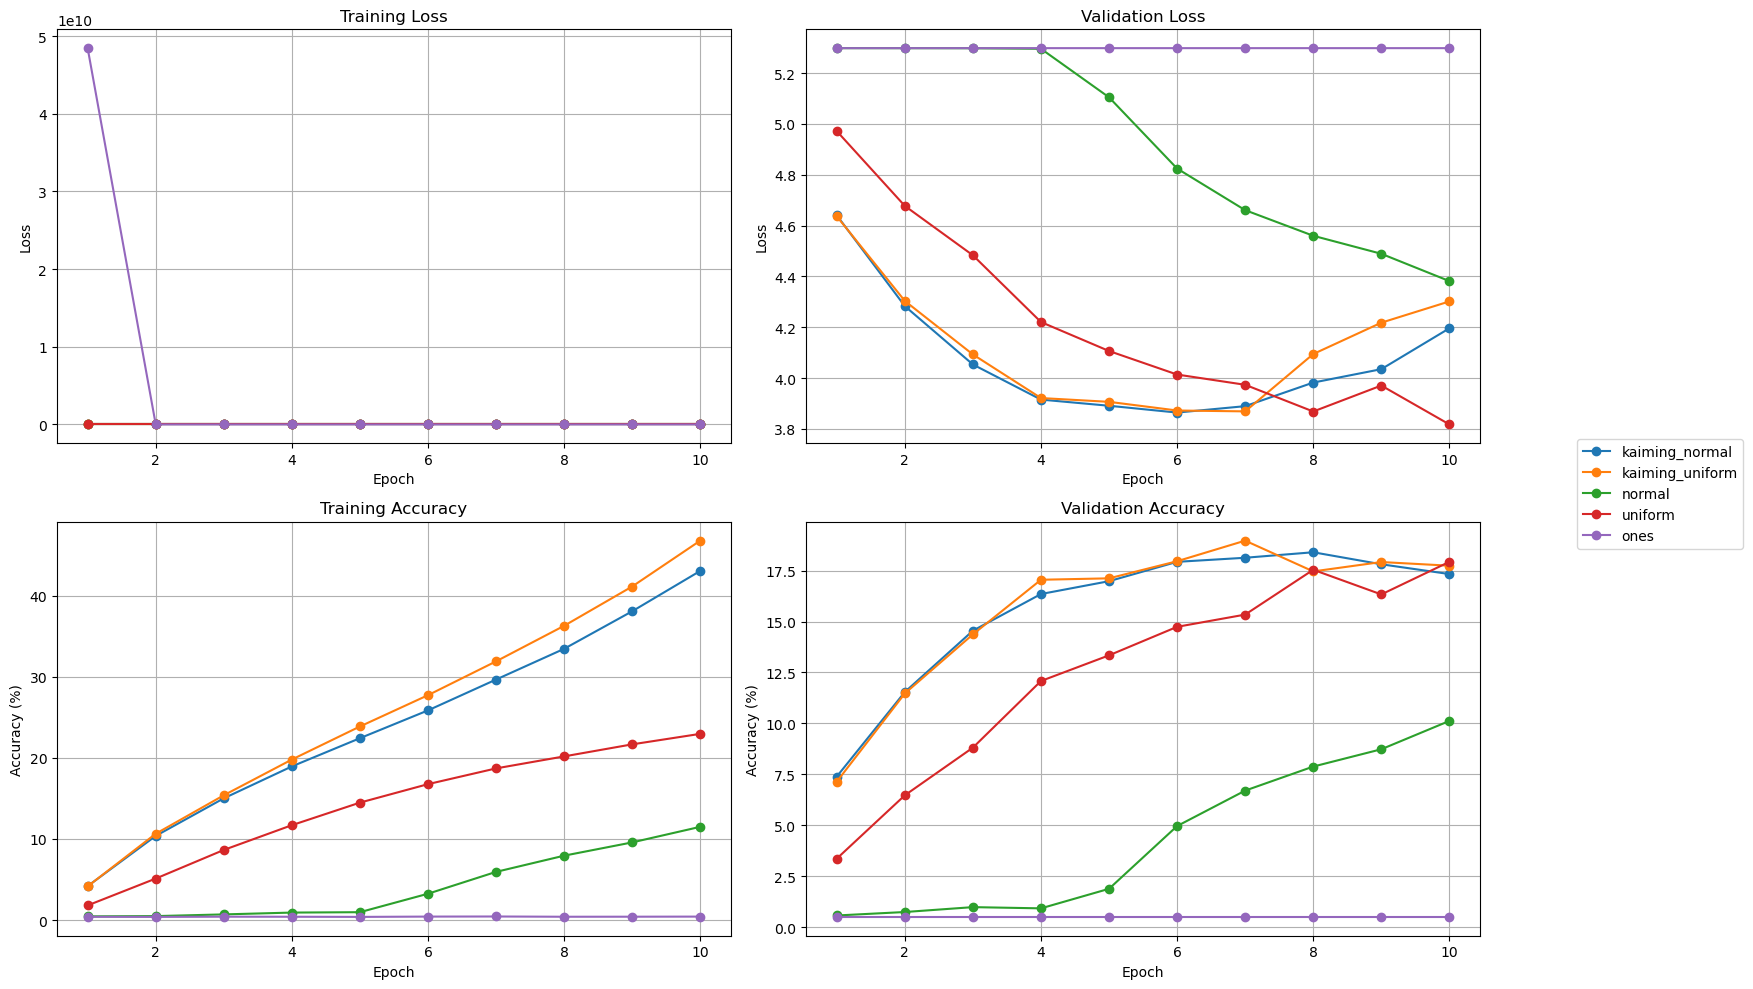

In [81]:
import importlib
import plot_conv

importlib.reload(plot_conv)
from plot_conv import plot_conv_settings

with open("results/weight_init_results.json", "r") as f:
    weight_init_results = json.load(f)
plot_conv_settings(weight_init_results)

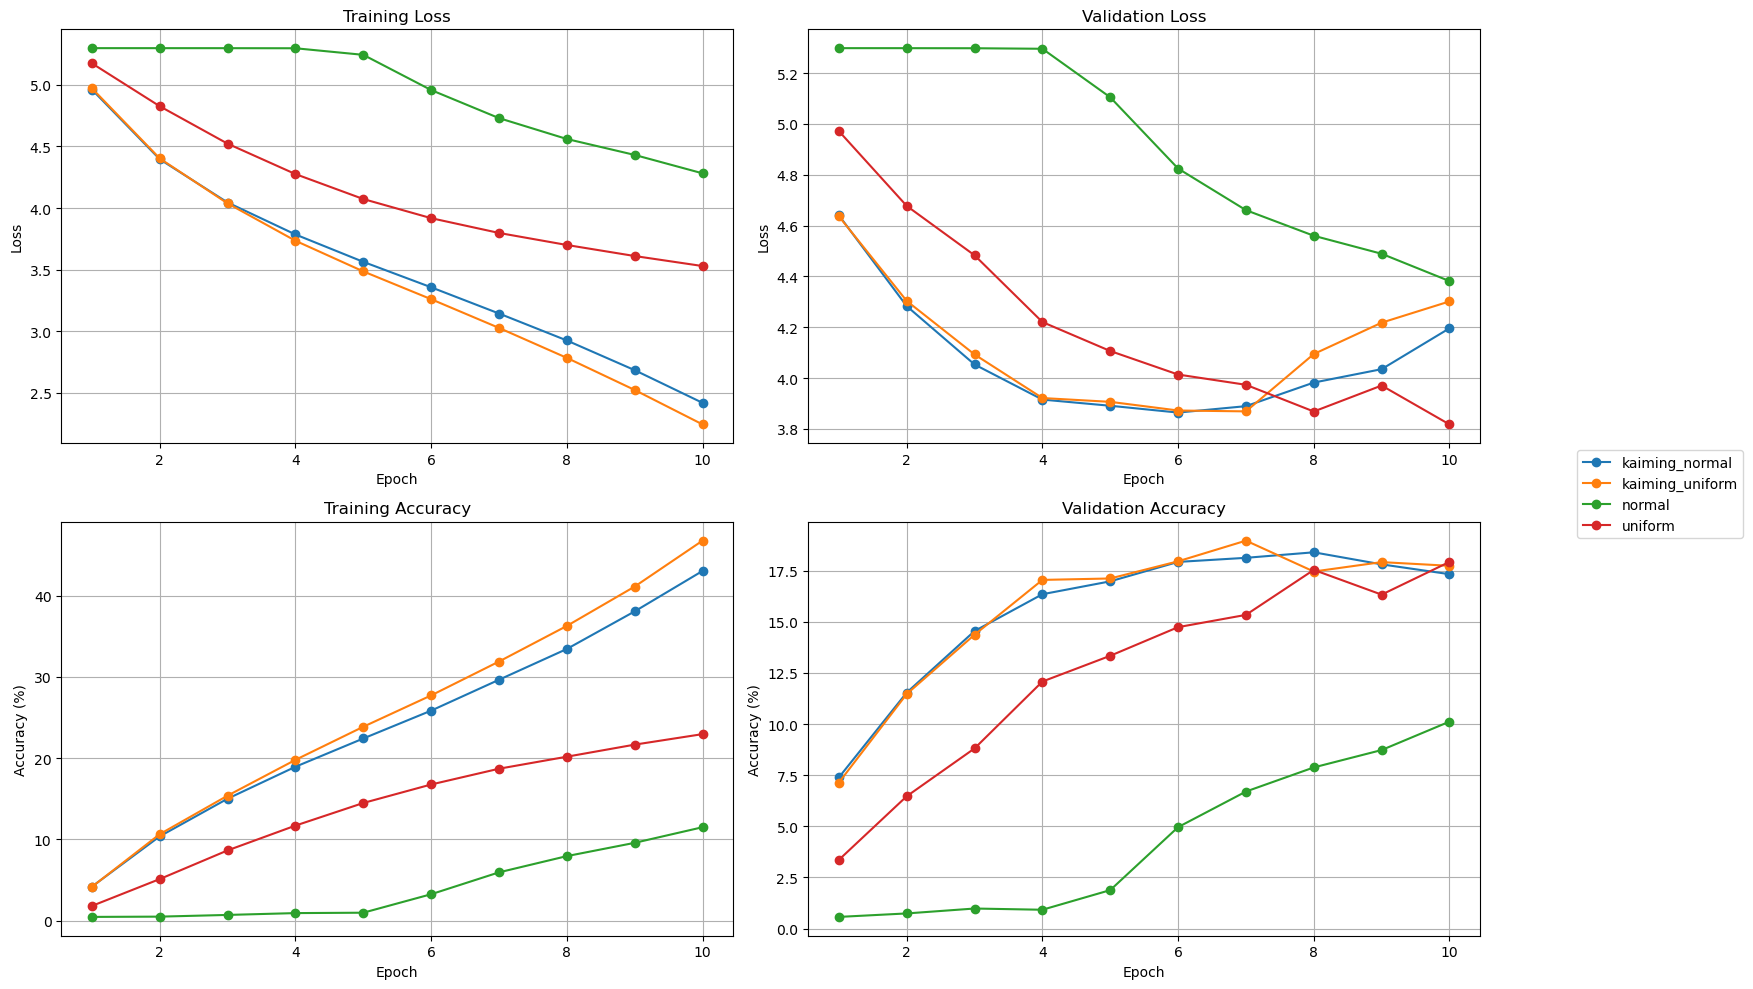

In [85]:
with open("results/weight_init_results.json", "r") as f:
    weight_init_results = json.load(f)
weight_init_results.pop("ones")
plot_conv_settings(weight_init_results)

### Discussion

- Initializing the weights with a normal distribution leads to super slow convergence. The model only starts learning after 5 epochs.
- Kaiming uniform and normal show similar results for the validation loss.
- However, initializing with uniform distribution seems to have the best performance on the validation set.

## Model Complexity
We will examine four different model variants with varying levels of complexity by adjusting the number of layers, units, or filters per layer. Additionally, we will monitor the learning curves to ensure that the training process remains stable.

I hypothesize that Tiny ImageNet will benefit from a deeper architecture—specifically, increasing the number of convolutional layers. This enhancement should enable the model to learn more complex patterns, and be get better in differentiation between 200 classes.

For the four proposed model variants, I will progressively increase the number of convolutional layers while decreasing the number of units in each dense layer. This strategy should mitigate overfitting by reducing the total number of parameters.

### Model Variant 1

**Architecture:**
- **Convolutional layers:**
  - 3x3 conv, 16 channels
  - 3x3 conv, 32 channels
  - Pooling layer with kernel size 2

- **Fully connected layers:**
  - fc 500 units
  - fc 500 units

**Evaluation:**
- This architecture includes two convolutional and two fully connected (linear) layers.
- The convolutional layers are effective for capturing spatial patterns within the input images.
- The fully connected layers, with 500 units each, significantly increase the number of parameter, which can raises the risk of overfitting.

**Future considerations:**
- Increase the number of convolutional layers.
- Reduce the number of units in the fully connected layers.

In [10]:
from train_eval import train

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 500}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
           Flatten-6                [-1, 28800]               0
            Linear-7                  [-1, 500]      14,400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                  [-1, 200]         100,200
Total params: 14,505,788
Trainable params: 14,505,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.14
Params size (MB): 55.34
Estimated Total Size (MB): 58.53
-----------------------------------

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

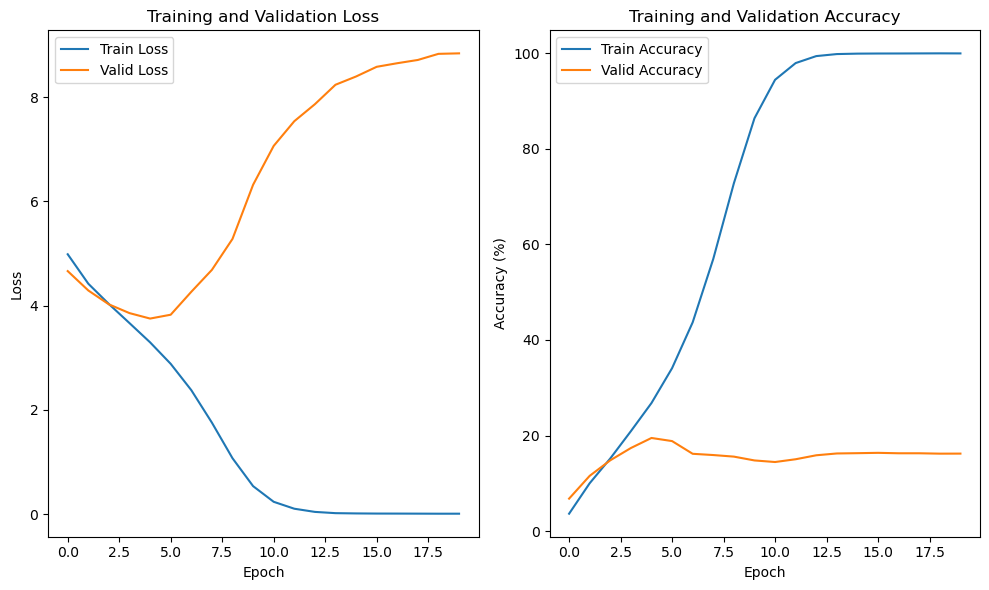

In [12]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 2

**Architecture Changes**:
- **Convolutional Layers**:
  - Initial layers: 3x3 conv, 16 and 3x3 conv, 32.
  - Additional layer added: 3x3 conv, 64.
- **Pooling**:
  - Two pooling layers with a stride of 2.
  - Spatial dimension reduced to 14x14.
- **Fully Connected Layers**:
  - Reduced units in the fully connected layer from 500 to 400.

**Parameter Impact**:
- The added convolutional layer with 64 filters (3x3 kernel) increases parameters by **18,400**.
- Reducing the fully connected layer units from 500 to 400 cuts linear parameters by more than half.

**Performance Expectation**:
- **Feature Extraction**: Enhanced by the added convolutional layer, increasing the depth of representation.
- **Overfitting Reduction**: Simplifying the fully connected layer may reduce overfitting.

In [7]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 400}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
         MaxPool2d-8           [-1, 64, 14, 14]               0
           Flatten-9                [-1, 12544]               0
           Linear-10                  [-1, 500]       6,272,500
             ReLU-11                  [-1, 500]               0
           Linear-12                  [-1, 200]         100,200
Total params: 6,396,284
Trainable params: 6,396,284
Non-trainable params: 0
---------------------------

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from utils import get_data
import importlib
import train_eval
importlib.reload(train_eval)
from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

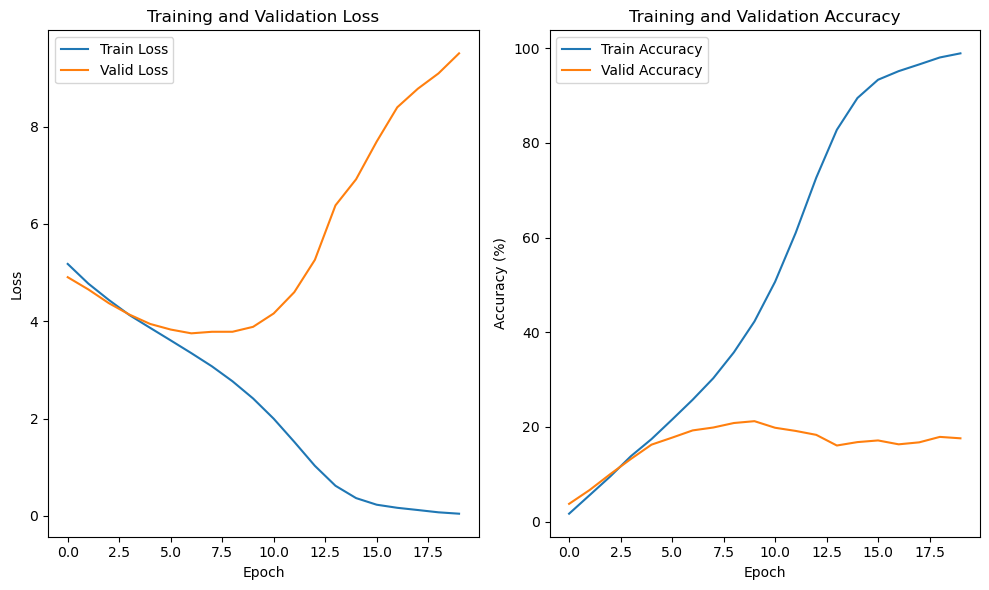

In [9]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 3

**Architecture**:

- **Convolution Layers**:
  - 3x3 conv, 16 channels
  - 3x3 conv, 32 channels
  - Pooling layer, stride 2
  - 3x3 conv, 64 channels
  - 3x3 conv, 64 channels
  - Pooling layer, stride 2

- **Fully Connected Layers**:
  - fc 500
  - fc 300

- **Parameter Increase**: Increased parameters in the convolutional layers from **18,400** to **36,900**, by adding consecutive convolutional layer.
- **Output Shape Comparison**: Output shape remains close to the previous architecture, adjusting from **(64, 14, 14)** to **(64, 13, 13)**.
- **Overfitting Consideration**: The depth could improve generalization.

In [4]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 300}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
          Flatten-11                [-1, 10816]               0
           Linear-12                  [-1, 500]       5,408,500
             ReLU-13                  [-1, 500]               0
           Linear-14                  [

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

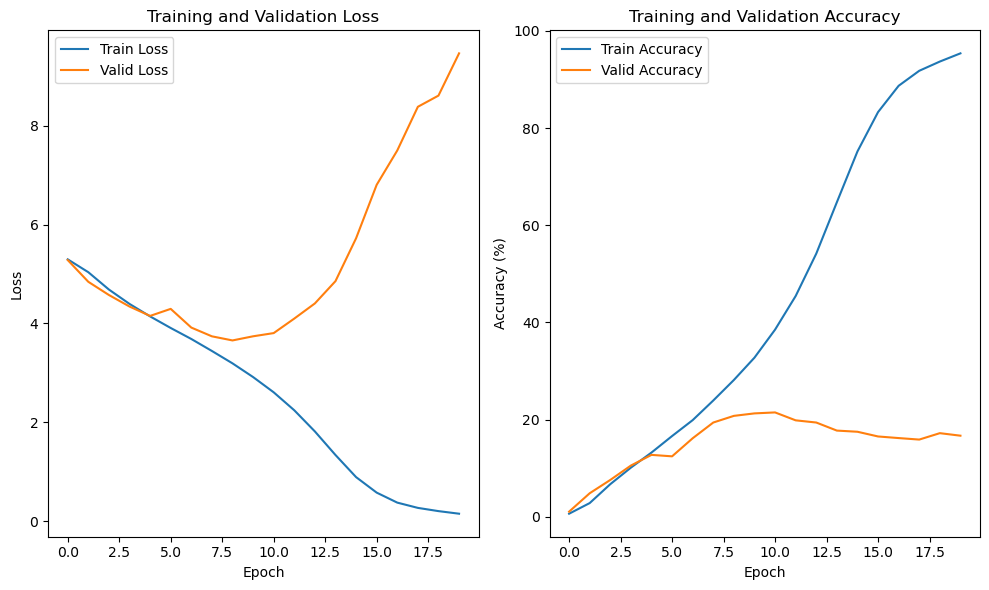

In [6]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Model Variant 4

Architecture:

- **Convolutional Layers**:
  - **First Stage**: Two 3x3 convolutional layers with 16 and 32 channels, followed by a pooling layer (stride 2) to reduce spatial dimensions.
  - **Second Stage**: Two 3x3 convolutional layers with 64 channels, followed by a pooling layer (stride 2).
  - **Third Stage**: Two 3x3 convolutional layers with 128 channels, followed by a pooling layer (stride 2).
- **Fully Connected Layers**:
  - First fully connected layer with 500 units.
  - Second fully connected layer with 200 units.

- **Feature Extraction**: The model applies three stages of convolutional layers with increasing channel depth (16, 32, 64, and 128), interspersed with pooling layers to downsample spatial dimensions.
- **Gradual Detail Extraction**: Multiple convolutional layers before each pooling step help extract detailed features progressively while reducing spatial dimensions.
- **Output Dimensions**: Starting with an input size of (3, 64, 64) for channels, height, and width, the model outputs a final feature map of (128, 4, 4), representing a dense, high-level feature representation.
- **Parameter Count**: Approximately 1.4 million parameters, which is the lowest so far.
- **Performance Expectation**: With this setup, the model should show the best performance so far by extracting the most patterns and saving them to the feature space.


In [1]:
from torchsummary import summary
import importlib
import cnn
importlib.reload(cnn)
from cnn import CNN
confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 128}),
    ("C", {"kernel": 3, "channels": 128}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <578455F2-C28A-3E71-B792-09499A54E249> /Users/hariveliki/miniconda3/envs/eml/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 128, 11, 11]          73,856
             ReLU-12          [-1, 128, 11, 11]               0
           Conv2d-13            [-1, 128, 9, 9]         147,584
             ReLU-14            [-1, 12

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from utils import get_data
from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
results = train(
    model,
    epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

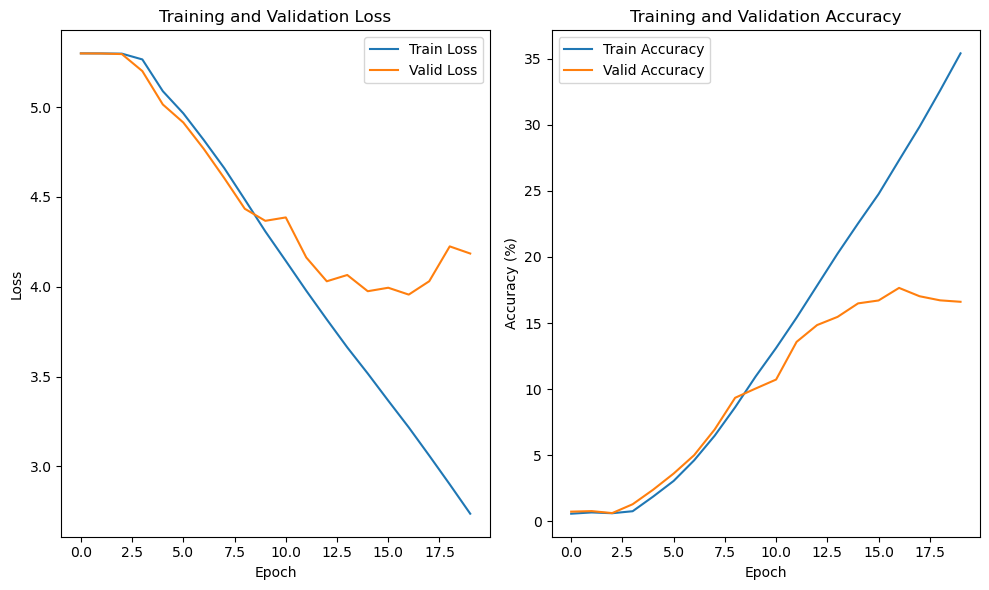

In [3]:
import importlib
import plot_train
importlib.reload(plot_train)
from plot_train import plot_train
plot_train(results)

### Convolutional Settings

Check which configuration (stride, padding, and kernel) provides the best performance.

In [44]:
from torchsummary import summary
import importlib
import cnn

importlib.reload(cnn)
from cnn import CNN


# default setting, kernel=3, padding=0 and stride=1
setting1 = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 128}),
    ("C", {"kernel": 3, "channels": 128}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
#kernel=2
setting2 = [
    ("C", {"kernel": 2, "channels": 16}),
    ("C", {"kernel": 2, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 2, "channels": 64}),
    ("C", {"kernel": 2, "channels": 64}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 2, "channels": 128}),
    ("C", {"kernel": 2, "channels": 128}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
#kernel=4
setting3 = [
    ("C", {"kernel": 4, "channels": 16}),
    ("C", {"kernel": 4, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 4, "channels": 64}),
    ("C", {"kernel": 4, "channels": 64}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 4, "channels": 128}),
    ("C", {"kernel": 4, "channels": 128}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
#padding=1, stride=1
setting4 = [
    ("C", {"kernel": 3, "channels": 16, "padding": 1}),
    ("C", {"kernel": 3, "channels": 32, "padding": 1}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64, "padding": 1}),
    ("C", {"kernel": 3, "channels": 64, "padding": 1}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 128, "padding": 1}),
    ("C", {"kernel": 3, "channels": 128, "padding": 1}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
# stride=2 works only with padding=2
setting5 = [
    ("C", {"kernel": 3, "channels": 16, "padding": 2, "stride": 2}),
    ("C", {"kernel": 3, "channels": 32, "padding": 2, "stride": 2}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64, "padding": 2, "stride": 2}),
    ("C", {"kernel": 3, "channels": 64, "padding": 2, "stride": 2}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 128, "padding": 2, "stride": 2}),
    ("C", {"kernel": 3, "channels": 128, "padding": 2, "stride": 2}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 200}),
]
settings = [
    ("kernel=3, stride=1, padding=0", setting1),
    ("kernel=2, stride=1, padding=0", setting2),
    ("kernel=4, stride=1, padding=0", setting3),
    ("kernel=3, stride=1, padding=1", setting4),
    ("kernel=3, stride=2, padding=2", setting5),
    
]
for name, setting in settings:
    model = CNN(dim=64, num_classes=200, confs=setting, in_channels=3)
    print(name.upper())
    summary(model, (64, 64, 3))

KERNEL=3, STRIDE=1, PADDING=0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 128, 11, 11]          73,856
             ReLU-12          [-1, 128, 11, 11]               0
           Conv2d-13            [-1, 128, 9, 9]         147,584
         

In [ ]:
import json
import torch
import torch.optim as optim
import torch.nn as nn
from utils import get_data
from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader = get_data(batch_size=64, seed=42)
conv_results = {}
for name, setting in settings:
    model = CNN(dim=64, num_classes=200, confs=setting, in_channels=3)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    model.to(device)
    history = train(
        model,
        epochs=15,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )
    conv_results[name] = history

with open("results/conv_results.json", "w") as f:
    json.dump(conv_results, f)


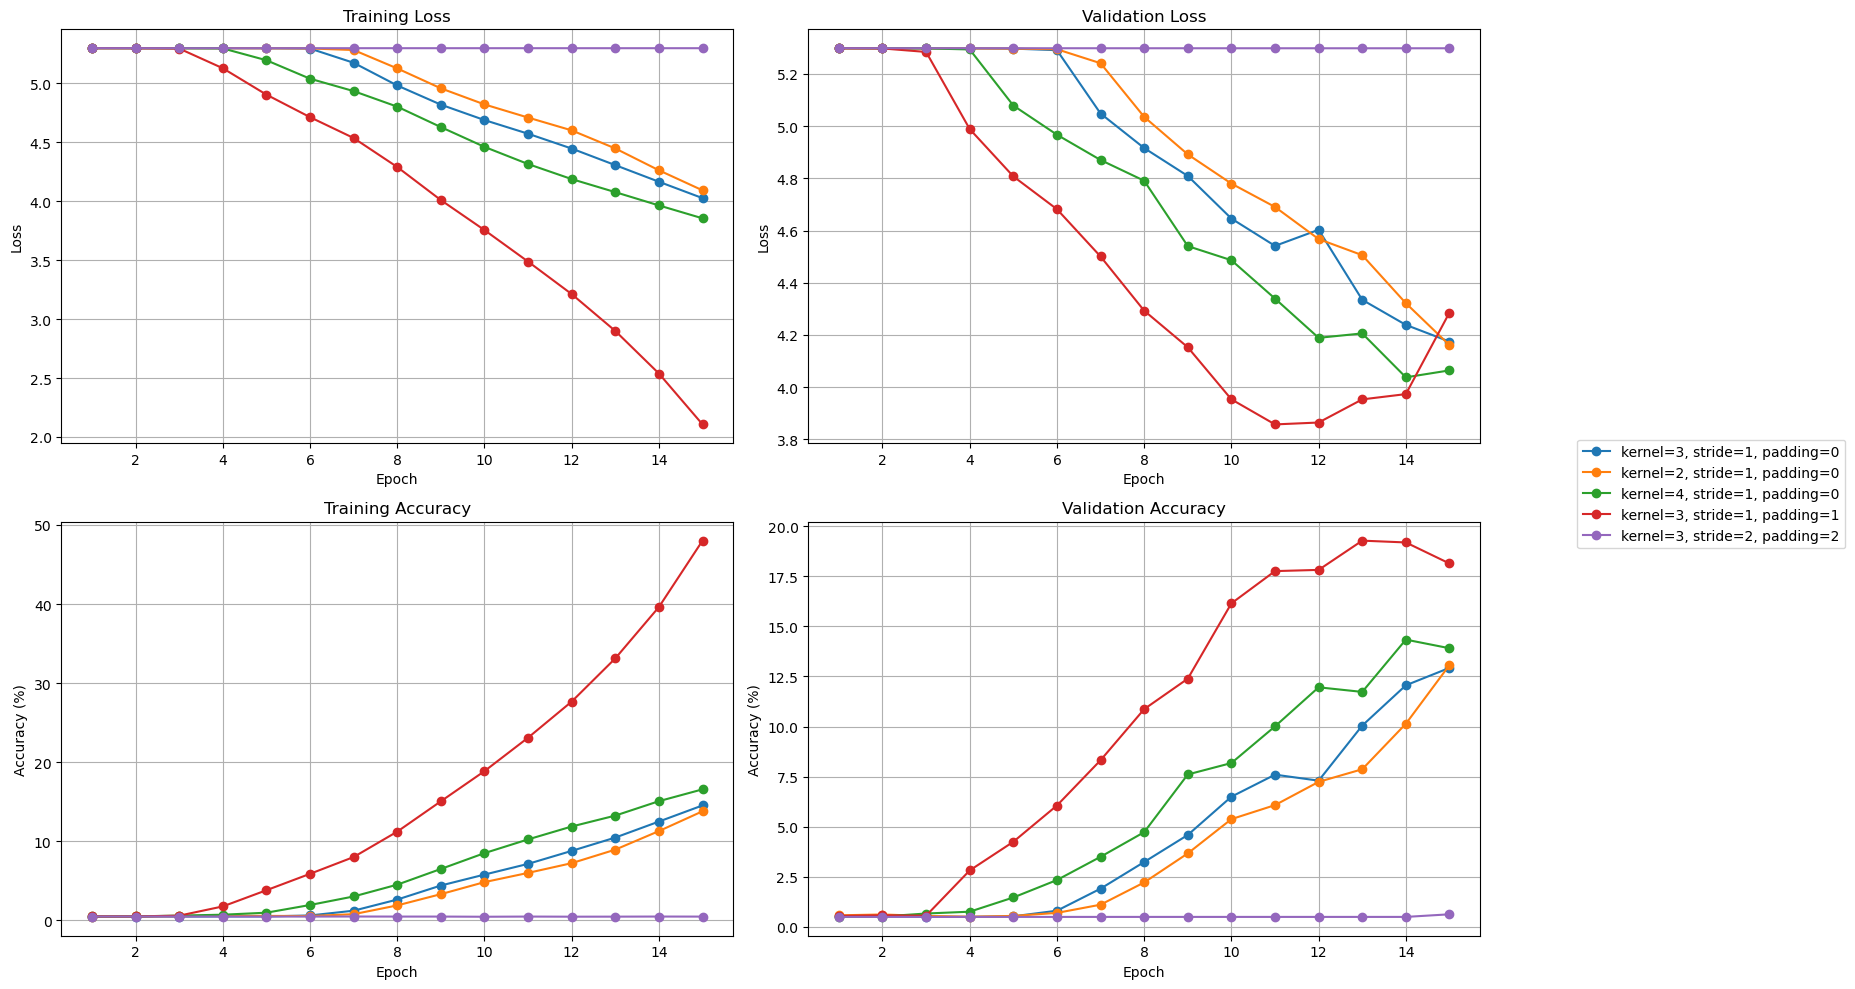

In [56]:
import importlib
import plot_conv
importlib.reload(plot_conv)
from plot_conv import plot_conv_settings
plot_conv_settings(conv_results)

### Discussion

**Model Complexity**

- Comparing the training and validation loss/accuracy plots from the first to the fourth model variant reveals:
  - The gap between training and validation loss narrows.
  - The same trend is observed for training and validation accuracy.
  - While the validation loss increased after 5 epochs in the first model, it only rises after 15 epochs in the last model.
  - Although accuracy on the training set reached 100% for the first three variants, the last layer achieves a maximum accuracy of 35% after 20 epochs.
  - The validation accuracy increases alongside the training accuracy, achieving the narrowest gap, but still remains between 15% and 20%.

The steady improvements from the first to the last variant are due to:
  - Increasing the number of convolutional layers, which expands the feature space and extracts more patterns from the images.
    - This increases the overall parameters only slightly compared to fully connected layers.
  - Reducing the units in the fully connected layers, decreasing the total parameters from 14.4 million to 1 million. This simplification prevents the model from overfitting.

**Convolutional Settings**

- kernel=3, stride=2, padding=2:
  - Poorest performance
  - Extensive stride and padding lead to no learning

- kernel=3, stride=1, padding=1:
  - Fast convergence, which leads to early overfitting (11 epochs)

- kernel=2/3/4, stride=1, padding=0:
  - Show similar results and best performance
  - Kernel=2 seems not to stagnate after 15 epochs compared to kernel=3 and kernel=4


**Conclusion**

Given the discussed results, the optimal setting for the model seems to be:

| Layer Type | Parameters |
|------------|------------|
| Conv2D     | kernel: 3x3, channels: 16 |
| Conv2D     | kernel: 3x3, channels: 32 |
| MaxPool2D  | kernel: 2x2 |
| Conv2D     | kernel: 3x3, channels: 64 |
| Conv2D     | kernel: 3x3, channels: 64 |
| MaxPool2D  | kernel: 2x2 |
| Conv2D     | kernel: 3x3, channels: 128 |
| Conv2D     | kernel: 3x3, channels: 128 |
| MaxPool2D  | kernel: 2x2 |
| Linear     | units: 500 |
| Linear     | units: 200 |

and for the convolutional layers:
- kernel=2, stride=1, and padding=0.

# Regularization

Regularization helps mitigate overfitting and enhances a model’s ability to generalize to unseen data. There are several ways to achieve regularization, two of which are:

**L1 and L2 Regularization**  
With L1 and L2 regularization, we penalize the model's weights by adding a regularization term to the loss function. This approach reduces the model's reliance on large weights.

- **L1 Regularization**: Adds the absolute value of each weight to the loss function. This encourages sparsity, often driving some weights to zero. The regularized loss function \( L \) with L1 regularization is:

  $$
  L = L_0 + \lambda \sum_{i} |w_i|
  $$

  where \( L_0 \) is the original loss, \( \lambda \) is the regularization strength, and \( w_i \) are the model weights.

- **L2 Regularization**: Adds the square of each weight to the loss function, discouraging large weights but not forcing them to zero, which helps smooth the learned patterns. The regularized loss function with L2 regularization is:

  $$
  L = L_0 + \lambda \sum_{i} w_i^2
  $$

**Dropout**  
In dropout, we randomly set a proportion \( p \) of units (neurons) to zero for each training update. By disabling certain connections, dropout prevents over-reliance on specific paths.

## L1/L2 Regularization

We will evaluate both L1 and L2 regularization methods by conducting multiple training runs with different regularization strengths (λ). Each method will be compared against a baseline model without regularization.

**Expectation**

**Training Loss:**
- Models with regularization should exhibit higher training loss
- This is expected because we're adding penalty terms to the loss function:
  - L1: λ∑|w| (sum of absolute weights)
  - L2: λ∑w² (sum of squared weights)
- The higher loss indicates that we're preventing the model from overfitting to the training data

**Validation Loss:**
- Models with regularization should demonstrate:
  - Lower validation loss in the long run
  - Better generalization to unseen data
  - Delayed onset of overfitting
- Without regularization:
  - Validation loss typically starts increasing early, i.e. shows earlier signs of overfitting
- With regularization:
  - Validation loss should remain stable for longer
  - The gap between training and validation loss should be smaller

We'll test this by comparing the following configurations:
- No regularization (baseline)
- L1 with λ ∈ {0.0001, 0.001, 0.01}
- L2 with λ ∈ {0.0001, 0.001, 0.01}

In [35]:
from torchsummary import summary
import importlib
import cnn
import l1_l2
importlib.reload(cnn)
importlib.reload(l1_l2)
from cnn import CNN

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 300}),
]
model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
summary(model, (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 60, 60]           4,640
              ReLU-4           [-1, 32, 60, 60]               0
         MaxPool2d-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 64, 28, 28]          18,496
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 26, 26]          36,928
              ReLU-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
          Flatten-11                [-1, 10816]               0
           Linear-12                  [-1, 500]       5,408,500
             ReLU-13                  [-1, 500]               0
           Linear-14                  [

In [ ]:
# L1 Regularization

import json
import torch
import torch.optim as optim
import torch.nn as nn
import l1_l2
importlib.reload(l1_l2)
from l1_l2 import train
from utils import get_data

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 300}),
]
device = torch.device("mps" if torch.backends.mps.is_available() else None)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
reg_configs = [
    {
        "name": "No Regularization",
        "l1_lambda": 0,
        "l2_lambda": 0,
    },
    {
        "name": "l1 0.00001",
        "l1_lambda": 0.00001,
        "l2_lambda": 0,
    },
    {
        "name": "l1 0.0001",
        "l1_lambda": 0.0001,
        "l2_lambda": 0,
    },
    {
        "name": "l1 0.001",
        "l1_lambda": 0.001,
        "l2_lambda": 0,
    },
]
l1_results = {}
for reg_config in reg_configs:
    print(reg_config["name"])
    model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    history = train(
        model,
        epochs=15,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        l1_lambda=reg_config["l1_lambda"],
        l2_lambda=reg_config["l2_lambda"],
    )
    l1_results[reg_config["name"]] = history
    print("\n")


with open("results/l1_results.json", "w") as f:
    json.dump(l1_results, f)

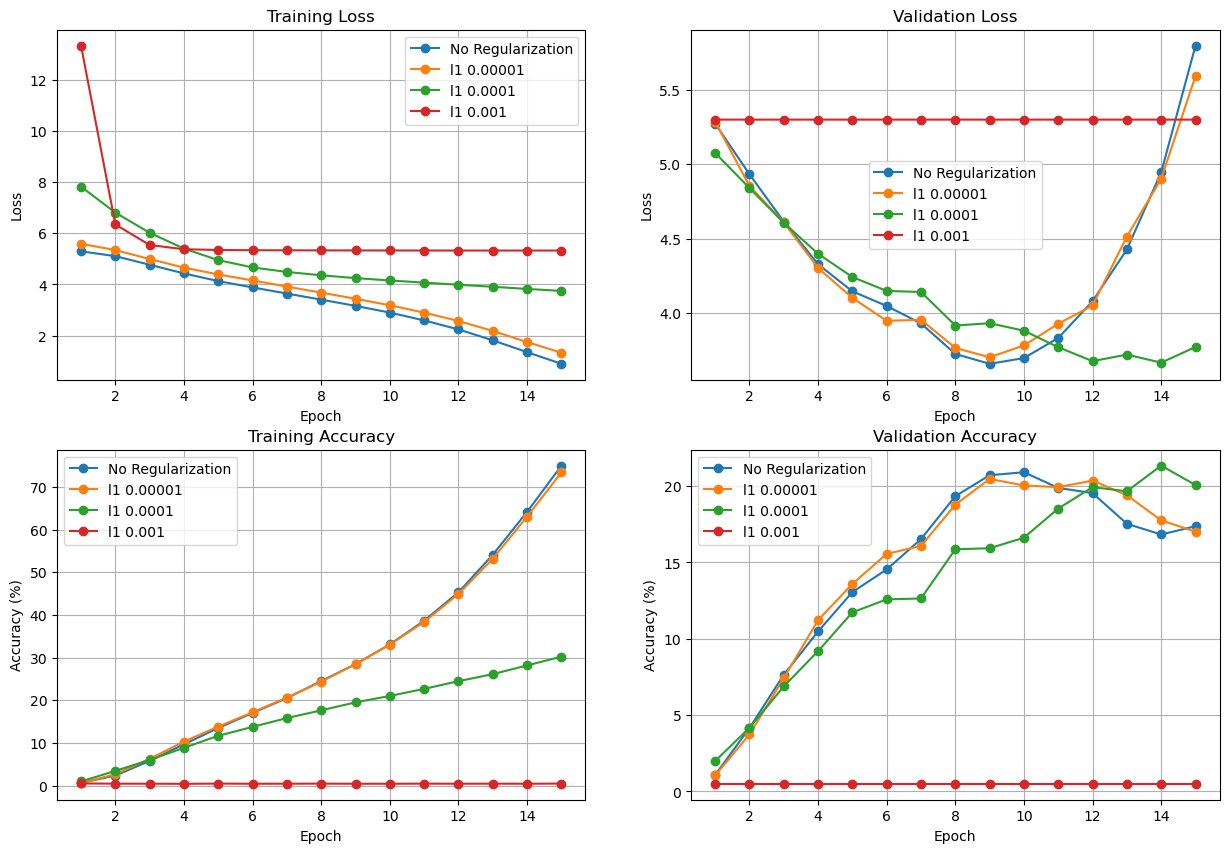

In [43]:
import importlib
import plot_reg
importlib.reload(plot_reg)
from plot_reg import plot_regularization_results
plot_regularization_results(l1_results)

In [ ]:
# L2 Regularization

import json
import torch
import torch.optim as optim
import torch.nn as nn
import l1_l2

importlib.reload(l1_l2)
from l1_l2 import train
from utils import get_data

confs = [
    ("C", {"kernel": 3, "channels": 16}),
    ("C", {"kernel": 3, "channels": 32}),
    ("P", {"kernel": 2}),
    ("C", {"kernel": 3, "channels": 64}),
    ("C", {"kernel": 3, "channels": 64}),
    ("P", {"kernel": 2}),
    ("L", {"units": 500}),
    ("L", {"units": 300}),
]
device = torch.device("mps" if torch.backends.mps.is_available() else None)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
reg_configs = [
    {
        "name": "No Regularization",
        "l1_lambda": 0,
        "l2_lambda": 0,
    },
    {
        "name": "l2 0.1",
        "l1_lambda": 0,
        "l2_lambda": 0.1,
    },
    {
        "name": "l2 0.05",
        "l1_lambda": 0,
        "l2_lambda": 0.05,
    },
    {
        "name": "l2 0.01",
        "l1_lambda": 0,
        "l2_lambda": 0.01,
    },
]
l2_results = {}
for reg_config in reg_configs:
    print(reg_config["name"])
    model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    history = train(
        model,
        epochs=15,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        l1_lambda=reg_config["l1_lambda"],
        l2_lambda=reg_config["l2_lambda"],
    )
    l2_results[reg_config["name"]] = history
    print("\n")

with open("results/l2_results.json", "w") as f:
    json.dump(l2_results, f)

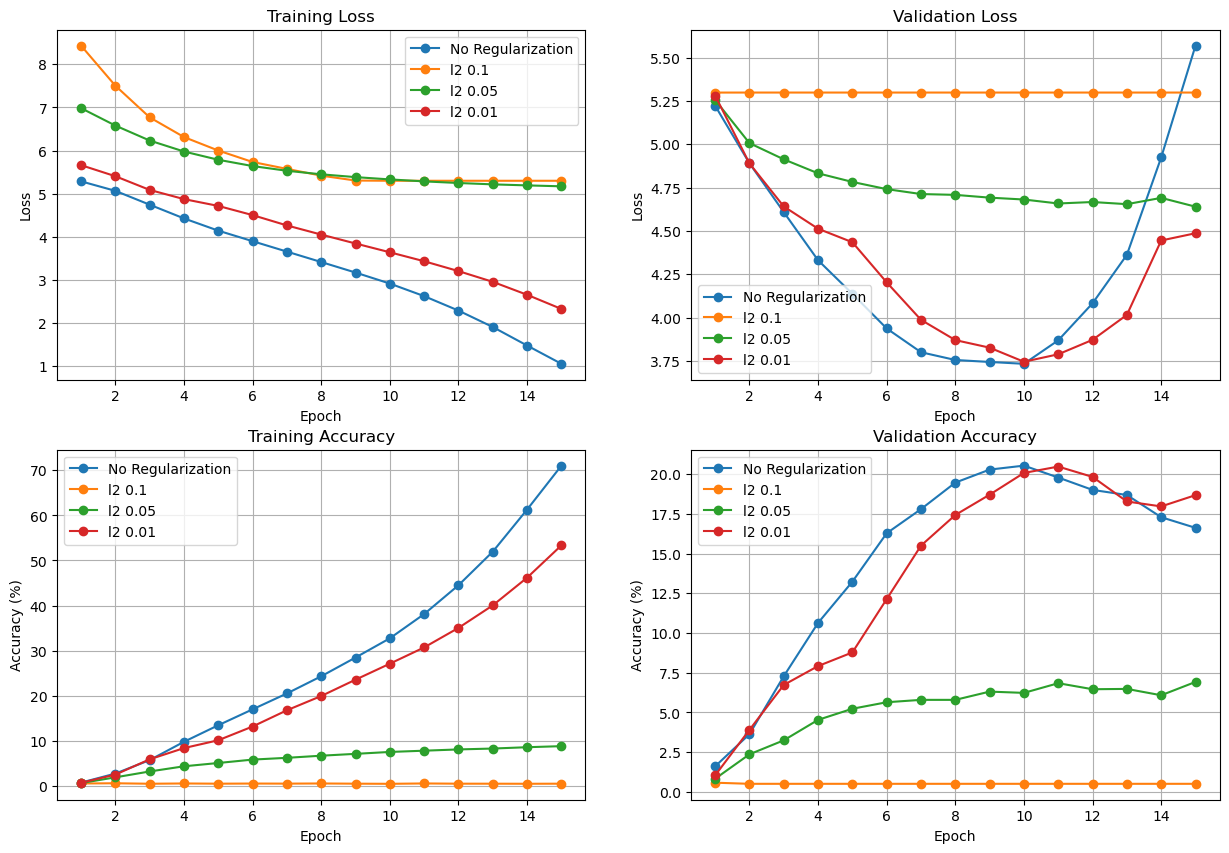

In [41]:
import importlib
import plot_reg
importlib.reload(plot_reg)
from plot_reg import plot_regularization_results
plot_regularization_results(l2_results)

### Discussion

**L1 Regularization**

- $\lambda=0.001$ is too high, halting the training completely by forcing some weights to 0.
- $\lambda=0.00001$ is too small and has nearly similar results to no regularization.
- $\lambda=0.0001$ has an effect and leads to better performance on the validation set.
- The optimal L1 strength $\lambda$ will lie between [1e-4, 1e-3], with values closer to 1e-4.

**L2 Regularization**

- L2 does not set weights exactly to 0, as shown by the smoother training loss curves (parameter values 0.05 and 0.1)
- Regularization strength of 0.1 is too high, as shown by the plateaued validation loss/accuracy
- Regularization strength of 0.01 starts overfitting at the same time as no regularization does (10 epochs)
- The regularization strength of 0.05 has decreasing validation loss but has very slow convergence
- The right regularization strength seems to lie between 0.01 and 0.05
  

**Conclusion**

L1 needs much lower strength values than L2, and L1 forces weights to zero, whereas L2 has a smoother regularization effect.
The optimal choice for L2 regularization lies in the range of [0.01, 0.05], whereas the optimal L1 strength is between [1e-4, 1e-3].
Because both show improved performance on the validation set compared to no regularization, there is no clear favorite.

## Dropout

We will apply dropout to the fully connected (linear) layers because:
- These layers contain the majority of the model's parameters and hence are most prone to overfitting.

The dropout probabilities will be proportional to the number of parameters in each layer:
- First linear layer: Higher dropout rate (e.g., 0.3)
  - Contains more parameters due to the transition from convolutional features
  - Maps from flattened conv output to units
- Second linear layer: Lower dropout rate (e.g., 0.1)
  - Contains fewer parameters
  - Maps from units to units

To evaluate the effectiveness of dropout, we'll compare three dropout configurations against a baseline.

For example:
1. Baseline (no dropout)
2. Light (0.2, 0.1)
3. Moderate (0.3, 0.1)
4. Heavier (0.4, 0.2)

In [ ]:
# Dropout Regularization

from train_eval import train

device = torch.device("mps" if torch.backends.mps.is_available() else None)
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
reg_configs = [
    {
        "name": "No Regularization",
        "dropout_1": 0,
        "dropout_2": 0,
    },
    {
        "name": "dropout 0.2 0.1",
        "dropout_1": 0.2,
        "dropout_2": 0.1,
    },
    {
        "name": "dropout 0.3 0.1",
        "dropout_1": 0.3,
        "dropout_2": 0.1,
    },
    {
        "name": "dropout 0.4 0.2",
        "dropout_1": 0.4,
        "dropout_2": 0.2,
    },
]
dropout_results = {}
for reg_config in reg_configs:
    confs = [
        ("C", {"kernel": 3, "channels": 16}),
        ("C", {"kernel": 3, "channels": 32}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 64}),
        ("C", {"kernel": 3, "channels": 64}),
        ("P", {"kernel": 2}),
        ("L", {"units": 500, "dropout": reg_config["dropout_1"]}),
        ("L", {"units": 300, "dropout": reg_config["dropout_2"]}),
    ]
    model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    history = train(
        model,
        epochs=15,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )
    dropout_results[reg_config["name"]] = history

import json

with open("results/dropout_results.json", "w") as f:
    json.dump(dropout_results, f)

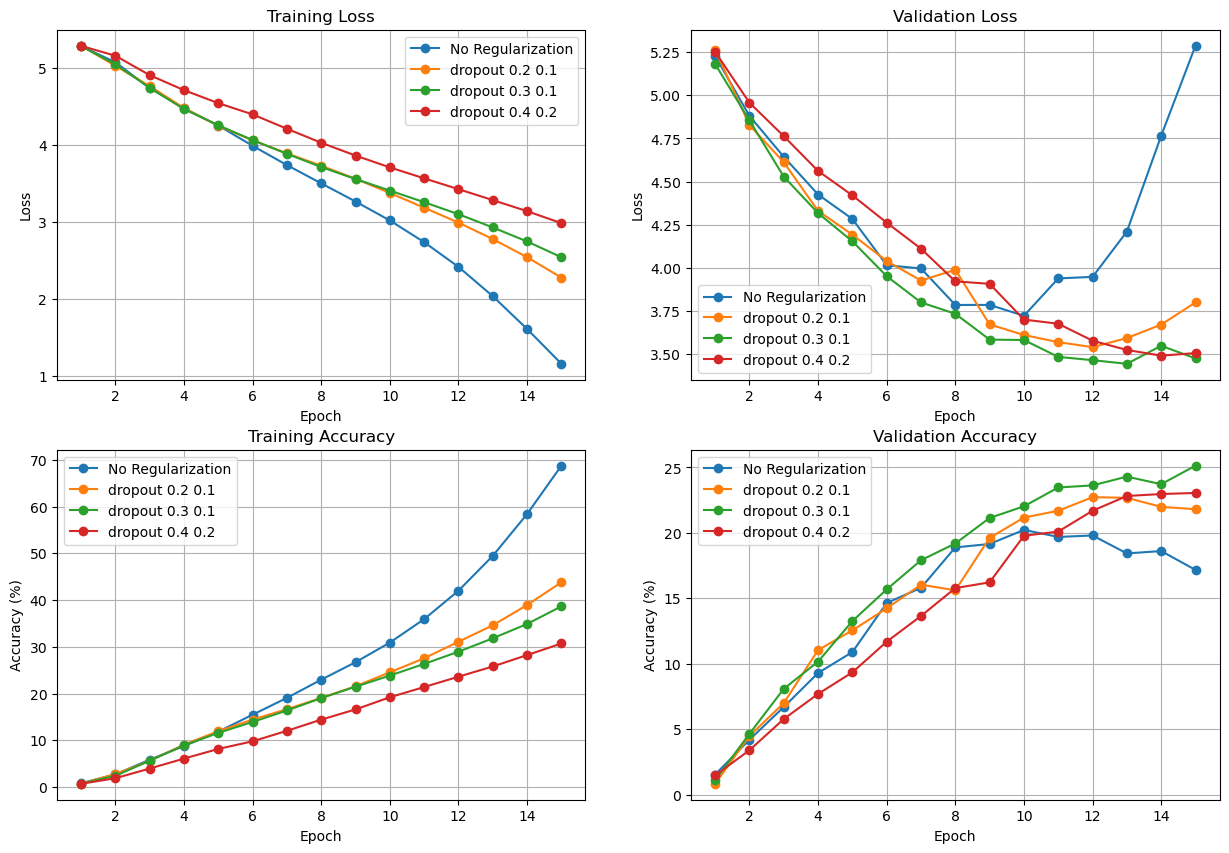

In [84]:
import importlib
import plot_reg
importlib.reload(plot_reg)
from plot_reg import plot_regularization_results
plot_regularization_results(dropout_results)

### Discussion

- Without dropout, the model starts overfitting after 10 epochs
- With dropout, the model continues to generalize well up to 15 epochs
- Among the dropout variants tested:
  - Higher dropout rates (0.3-0.4 for first layer, 0.1-0.2 for second layer) show better performance
  - Lower dropout rates (0.2 for first layer, 0.1 for second layer) are less effective at preventing overfitting

## Conclusion

- All three regularization methods (Dropout, L1, and L2) are effective in preventing model overfitting
- All three methods should definitely be favored over the baseline (no regularization)
- Dropout should be favored over L1 and L2 regularization because:
  - It shows better generalization capability (maintains performance up to 15 epochs, compared to 10)
  - Parameter tuning is more straightforward, with values constrained between [0,1]
  - The learning curves are more stable (less volatility)
  - The concept of dropout using probabilities is more intuitive to understand

# Batch Normalization (without REG, with SGD)

Batch Normalization is a technique to normalize the inputs to each layer in the network.

For a batch of size m, given input x, BatchNorm computes:

$$ \text{BatchNorm}(x) = \gamma \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} + \beta $$

where:
- μᵦ is the batch mean
- σᵦ² is the batch variance
- ε is a small constant for numerical stability
- γ, β are learnable parameters

For each feature (channel):

1. Normalizes the values across the current batch to have zero mean and unit variance
2. Applies learnable scale (γ) and shift (β) parameters
3. During backprop, these parameters are updated along with the rest of the networks weights, to learn the optimal scale and shift for each feature.

Key benefits:
- Reduces internal covariate shift (changes in the distribution of layer inputs during training)
- Faster convergence
- Allows higher learning rates
- Helps mitigate vanishing/exploding gradients by keeping activations in a reasonable range

In [ ]:
import json

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
batchnorm_results = {}
batch_confs = [
    {"name": "Batchnorm", "batch_norm": True},
    {"name": "No Batchnorm", "batch_norm": False},
]
for conf in batch_confs:
    confs = [
        ("C", {"kernel": 3, "channels": 16, "batch_norm": conf["batch_norm"]}),
        ("C", {"kernel": 3, "channels": 32, "batch_norm": conf["batch_norm"]}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 64, "batch_norm": conf["batch_norm"]}),
        ("C", {"kernel": 3, "channels": 64, "batch_norm": conf["batch_norm"]}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 128, "batch_norm": conf["batch_norm"]}),
        ("C", {"kernel": 3, "channels": 128, "batch_norm": conf["batch_norm"]}),
        ("P", {"kernel": 2}),
        ("L", {"units": 500, "batch_norm": conf["batch_norm"]}),
        ("L", {"units": 200, "batch_norm": conf["batch_norm"]}),
    ]
    model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    model.to(device)
    history = train(
        model,
        epochs=15,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        l1_lambda=0,
        l2_lambda=0,
    )
    batchnorm_results[conf["name"]] = history

with open("results/batchnorm_results.json", "w") as f:
    json.dump(batchnorm_results, f)

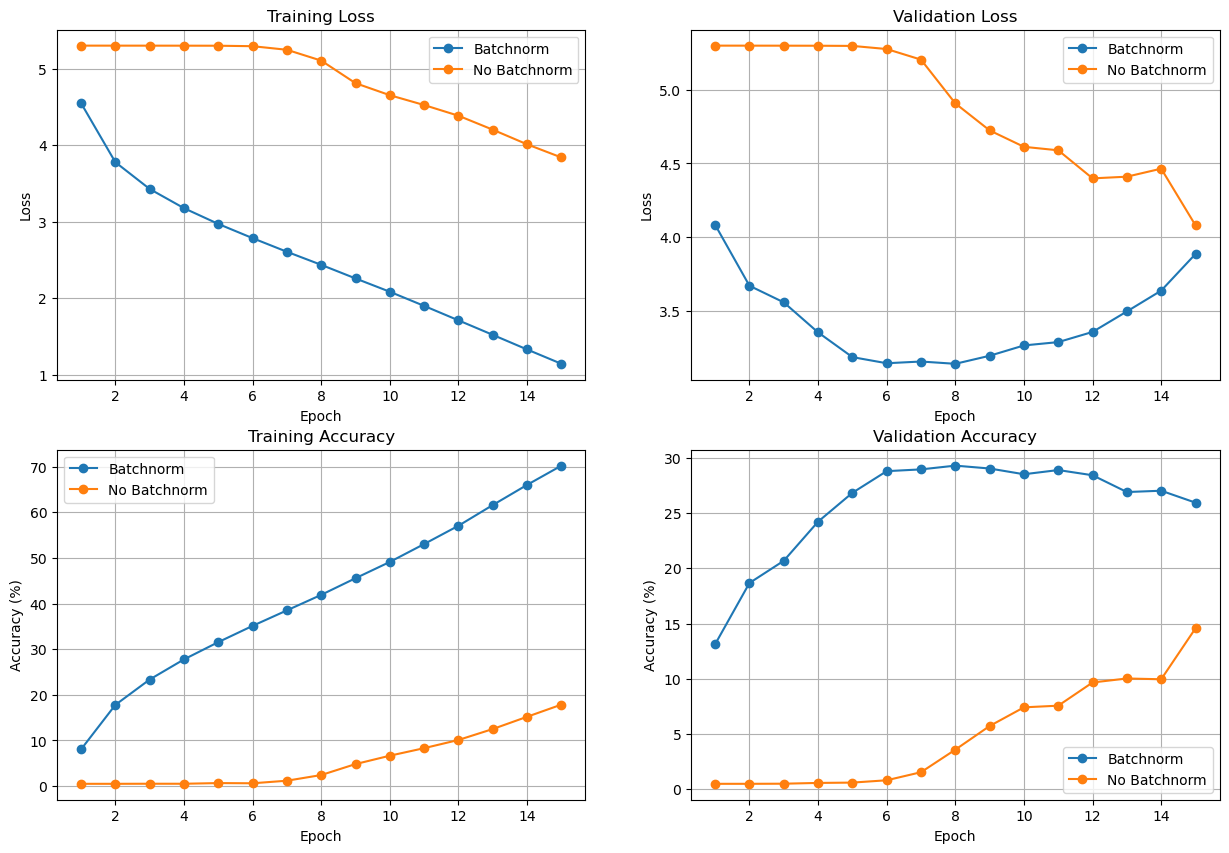

In [25]:
import importlib
import plot_reg
importlib.reload(plot_reg)
from plot_reg import plot_regularization_results
plot_regularization_results(batchnorm_results)

## Discussion

We observe:

- Convergence was achieved significantly faster compared to baseline
- Signs of overfitting were observed after 8 epochs
- Higher accuracy was demonstrated overall

1. **Convergence and Overfitting**
   - Faster convergence can be attributed to gradient updates that were stabilized and covariate shift that was reduced
   - Earlier overfitting was triggered by this accelerated training
   - Faster Training = Faster Overfitting

2. **Considerations**

   a) **Early Stopping**
      - Training could be terminated around epoch 8 when validation metrics begin to diverge

   b) **Batch Statistics**
      - Differences between training and validation batch statistics should be anticipated
      - Smaller Batch = Greater Noise
      - Larger batch sizes could be considered

   c) **Additional Regularization**
      - BatchNorm could be combined with other regularization techniques like dropout or L2, to prevent overfitting

# Adam

Adam is an optimizer that maintains two additional values for each parameter:

- A running average of past gradients (momentum)
- A running average of squared past gradients (velocity)

By doing so:

- Each parameter's learning rate is adjusted based on its gradient history
- Parameters that receive **large** or **frequent** updates will get smaller learning rates
- Parameters that receive **smaller** or **less frequent** updates will get bigger learning rates

Expectations:
- Adam should converge faster compared to SGD
- Adam with regularization could mitigate overfitting

In [ ]:
# ADAM vs SGD

import matplotlib.pyplot as plt
import json

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
train_loader, valid_loader = get_data(batch_size=64, seed=42)
criterion = nn.CrossEntropyLoss()
adam_configs = [
    {"name": "SGD"},
    {"name": "Adam"},
    {"name": "Adam L1", "l1": 0.0001},
    {"name": "Adam L2", "l2": 0.1},
    {"name": "Adam Dropout", "dropout": 0.4},
]
adam_results = {}
for config in adam_configs:
    confs = [
        ("C", {"kernel": 3, "channels": 16}),
        ("C", {"kernel": 3, "channels": 32}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 64}),
        ("C", {"kernel": 3, "channels": 64}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 128}),
        ("C", {"kernel": 3, "channels": 128}),
        ("P", {"kernel": 2}),
        ("L", {"units": 500, "dropout": config.get("dropout", 0)}),
        ("L", {"units": 200, "dropout": config.get("dropout", 0) * 0.5}),
    ]
    model = CNN(dim=64, num_classes=200, confs=confs, in_channels=3)
    if "Adam" in config["name"]:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif "SGD" in config["name"]:
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError(f"Invalid optimizer: {config['name']}")
    model.to(device)
    history = train(
        model,
        epochs=10,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        l1_lambda=config.get("l1", 0),
        l2_lambda=config.get("l2", 0),
    )
    adam_results[config["name"]] = history

with open("adam.json", "w") as f:
    json.dump(adam_results, f)

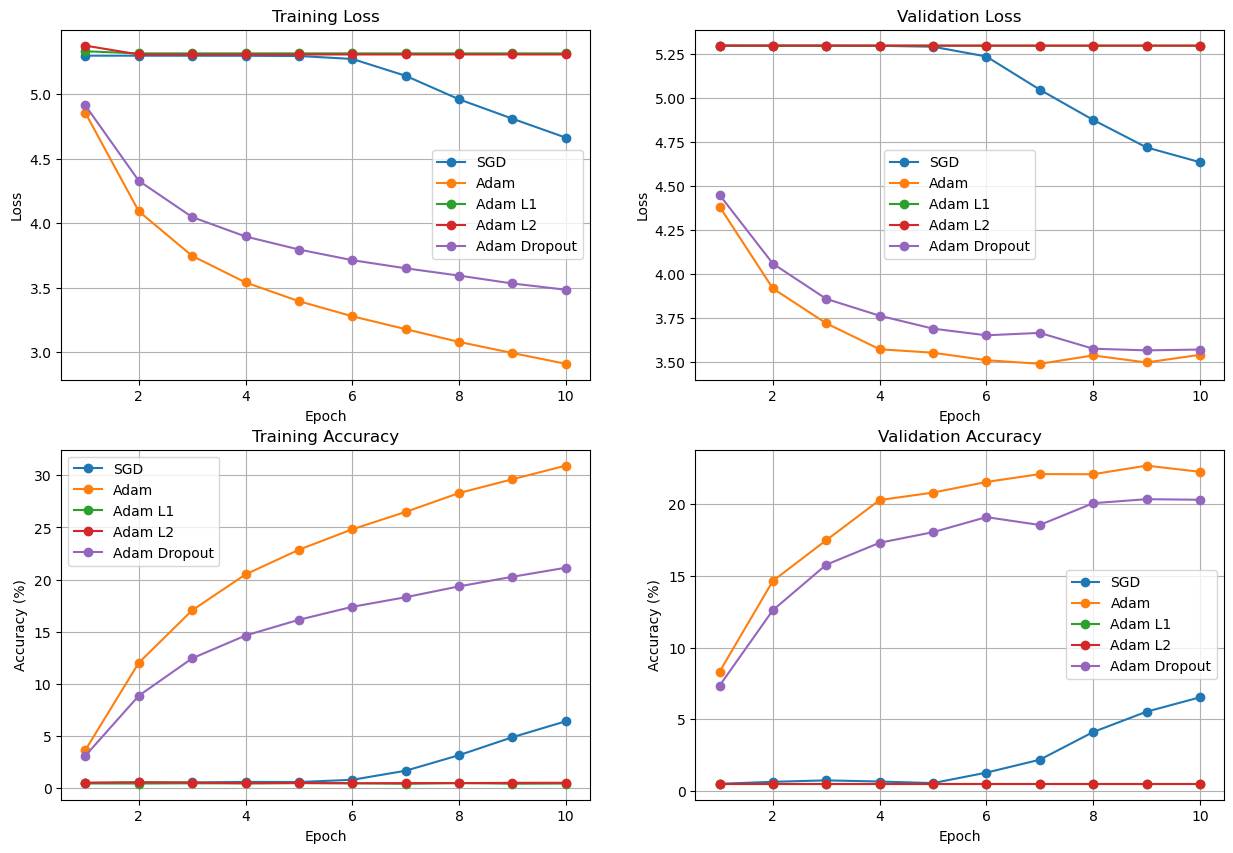

In [27]:
import importlib
import plot_reg
importlib.reload(plot_reg)
from plot_reg import plot_regularization_results
plot_regularization_results(adam_results)

## Discussion

We observe:

1. **Convergence**
   - Adam converges significantly faster than SGD, due to Adam's adaptive learning rates 

2. **Regularization Effects**
   - Dropout shows the most promising results when combined with Adam
   - L1 and L2 regularization appear less effective with Adam, possibly because:
     - Adam's adaptive learning rates may already provide some implicit regularization
     - The chosen regularization strengths might need adjustment for Adam

3. **Validation Performance**
   - Adam (+ Dropout) shows the best validation performance

Considerations:
1. Adam as the default optimizer for this architecture
2. Considering higher dropout rates (e.g., 0.5, 0.6) to potentially improve generalization
3. If using L1/L2 regularization with Adam, implement it through AdamW or adjust the regularization strengths

Conclusion:

Adam (with dropout) provides the best balance of training speed and model performance so far.

# Confidence

We will assess the model's reliability using k-fold cross-validation. This technique helps us:
1. Estimate the confidence interval of our model's performance
2. Understand how the model's predictions vary when trained on different subsets of data
3. Evaluate the stability and generalizability of our results

`!IMPORTANT!`

When implementing k-fold cross-validation for classification tasks, stratification is important:

**Why**
   - Without stratification, random splitting might create imbalanced folds
   - Some validation sets might miss certain classes entirely
   - This would lead to:
     - Impossible learning scenarios for missing classes
     - Skewed performance metrics
     - Unreliable model evaluation

**Example**
   - Consider a dataset with 100 samples and k=5:
     - Each fold contains 20 samples
     - Without stratification: Some classes might be entirely missing from validation
     - With stratification: Each fold maintains the original class distribution

**Solution**
   - We use `StratifiedKFold` from scikit-learn
   - It ensures:
     - Proportional representation of all classes in each fold
     - Balanced class distribution between training and validation sets
     - More reliable cross-validation results

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
       BatchNorm2d-3           [-1, 16, 64, 64]              32
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        MaxPool2d-14           [-1, 64,

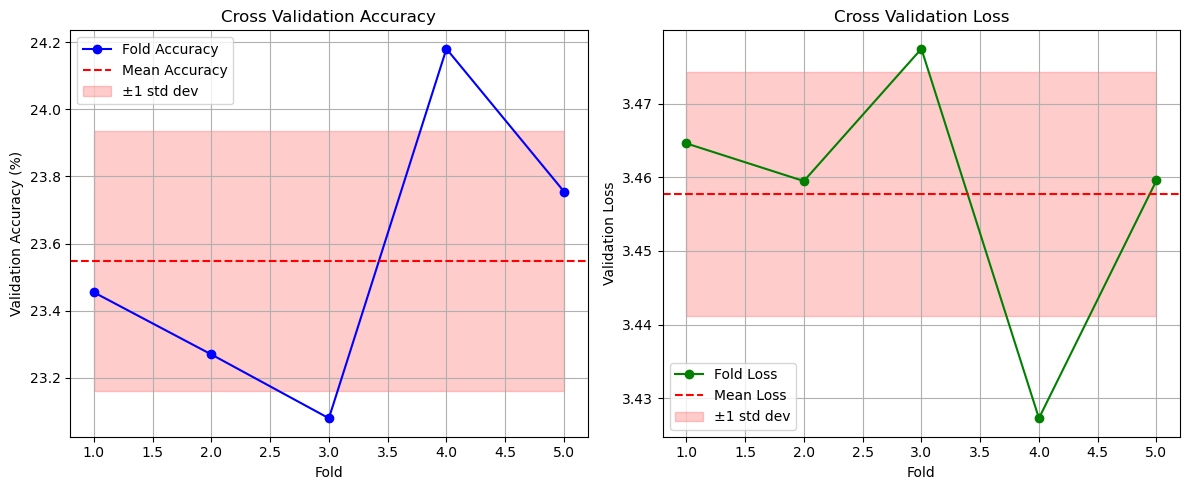

In [3]:
# Confidence
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from get_data import get_data
from cnn import CNN
from train_eval import train
from torchsummary import summary
from plot_confidence import plot_confidence
from plot_train import plot_train
from sklearn.model_selection import StratifiedKFold

K = 5
BATCH_SIZE = 64
EPOCHS = 10
SEED = 42


def k_fold_cross_validation(k=5, epochs=10, batch_size=64, seed=42):
    confs = [
        ("C", {"kernel": 3, "channels": 16, "padding": 1, "batch_norm": True}),
        ("C", {"kernel": 3, "channels": 32, "padding": 1, "batch_norm": True}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 64, "padding": 1, "batch_norm": True}),
        ("C", {"kernel": 3, "channels": 64, "padding": 1, "batch_norm": True}),
        ("P", {"kernel": 2}),
        ("C", {"kernel": 3, "channels": 128, "padding": 1, "batch_norm": True}),
        ("C", {"kernel": 3, "channels": 128, "padding": 1, "batch_norm": True}),
        ("P", {"kernel": 2}),
        ("L", {"units": 500, "dropout": 0.4}),
        ("L", {"units": 200, "dropout": 0.1}),
    ]
    model = CNN(
        dim=64,
        num_classes=200,
        confs=confs,
        in_channels=3,
        weight_init="kaiming",
    )
    summary(model, (3, 64, 64))
    train_loader, _ = get_data(batch_size=batch_size, seed=seed)
    full_dataset = train_loader.dataset

    targets = [y for _, y in full_dataset]

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(
        skf.split(np.zeros(len(targets)), targets)
    ):
        train_idx = [int(i) for i in train_idx]
        val_idx = [int(i) for i in val_idx]

        val_idx = val_idx[: len(val_idx)]
        train_idx = [
            int(i) for i in np.concatenate([train_idx, val_idx[len(val_idx) :]])
        ]
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(
            train_subset, batch_size=batch_size, shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            val_subset, batch_size=batch_size, shuffle=False
        )
        print("Training size:", len(train_loader.dataset))
        print("Validation size:", len(val_loader.dataset))
        model = CNN(
            dim=64,
            num_classes=200,
            confs=confs,
            in_channels=3,
            weight_init="kaiming",
        )
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        history = train(
            model,
            epochs=epochs,
            train_loader=train_loader,
            valid_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        plot_train(history, fold=fold + 1)
        fold_results.append(
            {
                "val_loss": history["valid_loss"][-1],
                "val_accuracy": history["valid_accuracy"][-1],
            }
        )
    val_losses = [r["val_loss"] for r in fold_results]
    val_accuracies = [r["val_accuracy"] for r in fold_results]
    stats = {
        "mean_val_loss": np.mean(val_losses),
        "std_val_loss": np.std(val_losses),
        "mean_val_accuracy": np.mean(val_accuracies),
        "std_val_accuracy": np.std(val_accuracies),
        "fold_results": fold_results,
    }
    return stats


stats = k_fold_cross_validation(k=K, epochs=EPOCHS, batch_size=BATCH_SIZE, seed=SEED)
print("\n Confidence Results:")
print(f"Validation Loss: {stats['mean_val_loss']:.4f} ± {stats['std_val_loss']:.4f}")
print(
    f"Validation Accuracy: {stats['mean_val_accuracy']:.2f}% ± {stats['std_val_accuracy']:.2f}%"
)
plot_confidence(stats)

## Discussion

We conducted k-fold cross-validation with k=5 and trained each fold for 10 epochs. The results demonstrate:

**Validation Accuracy**
- The model achieves a mean validation accuracy of 23.55% ± 0.39%
- Performance is highly consistent across folds, with variations less than 1%
- The tight confidence interval suggests reliable and reproducible model performance

**Validation Loss**
- Mean validation loss of 3.4577 ± 0.0166
- The small standard deviation in loss values (±0.0166) indicates:
  - Consistent learning behavior across different data splits
  - Stable optimization process
  - Reproducible training dynamics

The results show the architecture is stable and reliable.

# Conclusion

Through systematic experimentation and analysis, we identified the optimal configuration for the CNN model on the Tiny ImageNet dataset:

## Architecture & Training
- **Base Architecture**: Multiple convolutional layers with increasing channels (16→32→64→128), followed by two fully connected layers
- **Batch Size**: 64 (best trade-off between convergence and memory usage)
- **Learning Rate**: 0.01 (with SGD) or 0.001 (with Adam)
- **Weight Initialization**: Uniform (-0.1 and 0.1) or kaiming

## Optimization Techniques
1. **Regularization**:
   - Dropout proved most effective (0.4 for first FC layer, 0.2 for second)
   - L1/L2 regularization also helped but required more careful parameter tuning

2. **Batch Normalization**:
   - Significantly improved convergence speed
   - Should be combined with dropout to prevent early overfitting

3. **Optimizer**:
   - Adam outperformed SGD in terms of convergence speed and validation performance

## Model Reliability
- Cross-validation (k=5) showed consistent performance:
  - Validation Accuracy: 23.55% ± 0.39%
  - Validation Loss: 3.4577 ± 0.0166
- Small standard deviations indicate stable and reproducible results

## Key Learnings
1. Small architectural decisions can significantly impact model performance
2. Regularization is a must for preventing overfitting
3. The combination of Adam optimizer, batch normalization, and dropout provides the best balance of training speed and model performance

This systematic approach to model development and evaluation provides a reliable foundation for classifying images for the Tiny ImageNet dataset.
